In [382]:
import config
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from operator import attrgetter
import datetime as dt
import seaborn as sns
import scipy.optimize
import math

In [383]:
# TODO: These names are already used in least_squares_criterion
N, I0, R0, S0, downloads_per_month, average_infection_rate, alpha, beta, t_start_milliseconds = attrgetter('N', 'I0', 'R0', 'S0', 'downloads_per_month', 'average_infection_rate', 'alpha', 'beta', 't_start_milliseconds')(config.FACEBOOK_SIR_CONSTANTS)

In [384]:
def convert_quarter_to_timestamp_milliseconds(quarter_str: str) -> float:
    quarter_index, year = map(int, quarter_str[1:].split())
    month = quarter_index * 3 - 2
    date = dt.datetime(year, month, 1)
    return date.timestamp() * 1000

mau = pd.read_csv(config.DATA_DIR / 'facebook_quarterly_monthly_active_users.csv')
mau['timestamp_milliseconds'] = mau['quarter'].apply(convert_quarter_to_timestamp_milliseconds)
I_real = mau['MAU']

In [385]:
t_step = 1e-1
t_start = 0
t_end = t_step * math.ceil(((list(mau['timestamp_milliseconds'])[-1] - t_start_milliseconds) / config.MILLISECONDS_IN_MONTH) / t_step)

wanted_months = (mau['timestamp_milliseconds'] - t_start_milliseconds) / config.MILLISECONDS_IN_MONTH

def get_nearest_indices(wanted_month):
    return {
        'lower_index': int(t_step * math.floor(wanted_month / t_step)),
        'upper_index': int(t_step * math.ceil(wanted_month / t_step)),
        'wanted_month': wanted_month,
    }

indices_month = np.vectorize(get_nearest_indices)(wanted_months)



def get_interpolated_I(indices_month_obj):
    I1 = I_arr[indices_month_obj['lower_index']]
    I2 = I_arr[indices_month_obj['upper_index']]
    t1 = t_arr[indices_month_obj['lower_index']]
    dI = I2 - I1
    dt = t_step
    rc = dI / dt
    t = indices_month_obj['wanted_month'] - t1
    I_interpolated = I1 + rc * t
    return I_interpolated

I_estimate = np.vectorize(get_interpolated_I)(indices_month)
print(I_estimate)

[1.93600000e+09 1.98221608e+09 2.02499814e+09 2.06428196e+09
 2.09960426e+09 2.13010152e+09 2.15719864e+09 2.18084966e+09
 2.20069173e+09 2.21606345e+09 2.22811934e+09 2.23682967e+09
 2.24192751e+09 2.24319041e+09 2.24099700e+09 2.23559818e+09
 1.98742205e+09 2.21437357e+09 2.19889784e+09 2.18038724e+09
 2.15875147e+09 2.13388276e+09 2.10616554e+09 2.07560642e+09
 2.04219530e+09]


In [386]:
def least_squares_criterion(theta):
    S0, I0, R0, alpha, beta = theta
    N = S0 + I0 + R0

    n_steps = int(1 + (t_end - t_start) / t_step) # FIXME:
    # error if (t_end - t_start) // t_step =/= int
    t_arr = np.linspace(t_start, t_end, n_steps, endpoint=True)

    S_arr = np.zeros(n_steps)
    I_arr = np.zeros(n_steps)

    S_arr[0] = S0
    I_arr[0] = I0

    for n, t_n in enumerate(t_arr[:-1]):
        S_arr[n + 1] = S_arr[n] + t_step * (-alpha / N * S_arr[n] * I_arr[n])
        I_arr[n + 1] = I_arr[n] + t_step * (alpha / N * S_arr[n] * I_arr[n] - beta * I_arr[n])

    def get_interpolated_I(indices_month_obj):
        I1 = I_arr[indices_month_obj['lower_index']]
        I2 = I_arr[indices_month_obj['upper_index']]
        t1 = t_arr[indices_month_obj['lower_index']]
        dI = I2 - I1
        dt = t_step
        rc = dI / dt
        t = indices_month_obj['wanted_month'] - t1
        I_interpolated = I1 + rc * t
        return I_interpolated
    
    I_estimate = np.vectorize(get_interpolated_I)(indices_month)

    # return np.sum((I_real - I_estimate) ** 2)
    return np.sum(np.abs(I_real - I_estimate))

max_population_count = 9e9
theta_bounds = scipy.optimize.Bounds(lb=(0, 0, 0, 0, 0), ub=(max_population_count, max_population_count, max_population_count, np.inf, np.inf))
# theta_bounds = None
theta_guess = (S0, I0, R0, alpha, beta)
theta_guess = (8999.999989328582 * 1e6, 2091.3725329982294 * 1e6, 391.5967421761192 * 1e6, 0.0229549598647329, 0.011219988332903545)
result: scipy.optimize.OptimizeResult = scipy.optimize.minimize(fun=least_squares_criterion, x0=theta_guess, method='nelder-mead', bounds=theta_bounds, options={
    # TODO: explain choices xatol and fatol
    'xatol': min(1, 1e-6),
    'fatol': 1e-5,
    # 'xatol': min(1, 1e-5),
    # 'fatol': 1e4,
    # 'fatol': 25 * (1e5 / 25) ** 2,
    # 'xatol': 1e15,
    # 'fatol': 0.4e9,
    # 'maxiter': 1e5,
    # 'maxfev': 1e5,
    'maxiter': np.inf,
    'maxfev': np.inf,
    'disp': True,
})

print(f'{result.success=}')
print(f'{result.status=}')
print(f'{result.message=}')
print(f'{result.nit=}')
print(f'{result.nfev=}')
theta_estimate = result.x

Optimization terminated successfully.
         Current function value: 1548574748.583730
         Iterations: 769
         Function evaluations: 1307
result.success=True
result.status=0
result.message='Optimization terminated successfully.'
result.nit=769
result.nfev=1307


In [387]:
val1 = 615325375130527104.000000
# val1 = 615325375130518912.000000
val2 = 615325375130518272.000000
np.abs(val1 - val2)
S0, I0, R0, alpha, beta = theta_estimate
N = S0 + I0 + R0
print(f'{S0/1e6=}')
print(f'{I0/1e6=}')
print(f'{R0/1e6=}')
print(f'{N/1e6=}')
print(f'{alpha=}')
print(f'{beta=}')

print(least_squares_criterion(theta_guess))

S0/1e6=8999.99870331936
I0/1e6=1943.5226236716542
R0/1e6=770.6076304332556
N/1e6=11714.12895742427
alpha=0.06583117691411733
beta=0.0396193645933454
2308158425.469223


In [388]:
# t_end = 15 * 12

# S0, I0, R0, alpha, beta = theta_estimate
# N = S0 + I0 + R0

n_steps = int(1 + (t_end - t_start) / t_step) # FIXME:
# error if (t_end - t_start) // t_step =/= int
t_arr = np.linspace(t_start, t_end, n_steps, endpoint=True)

S_arr = np.zeros(n_steps)
I_arr = np.zeros(n_steps)

S_arr[0] = S0
I_arr[0] = I0

for n, t_n in enumerate(t_arr[:-1]):
    S_arr[n + 1] = S_arr[n] + t_step * (-alpha / N * S_arr[n] * I_arr[n])
    I_arr[n + 1] = I_arr[n] + t_step * (alpha / N * S_arr[n] * I_arr[n] - beta * I_arr[n])

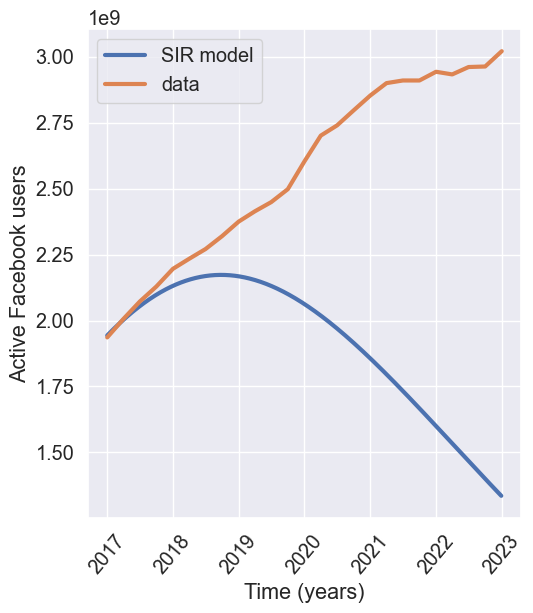

In [389]:
FIGURE_WIDTH = 7 * 4 / 5
FIGURE_HEIGHT = 8 * 4 / 5
LINEWIDTH = 3
FONT_SCALE = 1.3

MAX_YEAR = 2023
MAX_TIMESTAMP_MILLISECONDS = dt.datetime(MAX_YEAR, 1, 1).timestamp() * 1000

t_arr_milliseconds = t_arr * config.MILLISECONDS_IN_MONTH + t_start_milliseconds
sir_model = pd.DataFrame({
    # FIXME:
    'I': I_arr, 
    'timestamp_milliseconds': t_arr_milliseconds,
    # 'I': I_estimate,
    # 'timestamp_milliseconds': mau['timestamp_milliseconds'],
})
sir_model_cutoff = sir_model.loc[sir_model['timestamp_milliseconds'] <= MAX_TIMESTAMP_MILLISECONDS]
mau_cutoff = mau.loc[mau['timestamp_milliseconds'] <= MAX_TIMESTAMP_MILLISECONDS]

sns.set_theme()
sns.set(font_scale=FONT_SCALE) # TODO: REFACTOR
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

sns.lineplot(data=sir_model_cutoff, x='timestamp_milliseconds', y='I', label='SIR model', linewidth=LINEWIDTH)
sns.lineplot(data=mau_cutoff, x='timestamp_milliseconds', y='MAU', label='data', linewidth=LINEWIDTH)

def convert_year_to_timestamp_milliseconds(year: int) -> float:
    return dt.datetime(year, 1, 1).timestamp() * 1000

def format_timestamp_milliseconds(timestamp_milliseconds: float) -> str:
    datetime_obj = dt.datetime.fromtimestamp(timestamp_milliseconds / 1000)
    return datetime_obj.strftime('%Y')

years = list(range(2017, MAX_YEAR + 1)) # TODO: refactor met MAX_TIMESTAMP_MILLISECONDS
xticks = list(map(convert_year_to_timestamp_milliseconds, years))
xlabels = list(map(format_timestamp_milliseconds, xticks))

ax = plt.gca()
ax.set_xticks(xticks, xlabels, rotation=50)

plt.xlabel('Time (years)')
plt.ylabel('Active Facebook users')

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'basic_facebook_sir_model_fitted_parameters.svg')
plt.show()

In [391]:
N, I0, R0, S0, downloads_per_month, average_infection_rate, alpha, beta, t_start_milliseconds = attrgetter('N', 'I0', 'R0', 'S0', 'downloads_per_month', 'average_infection_rate', 'alpha', 'beta', 't_start_milliseconds')(config.FACEBOOK_SIR_CONSTANTS)

n_steps = int(1 + (t_end - t_start) / t_step) # FIXME:
# error if (t_end - t_start) // t_step =/= int
t_arr = np.linspace(t_start, t_end, n_steps, endpoint=True)

S_arr = np.zeros(n_steps)
I_arr = np.zeros(n_steps)

S_arr[0] = S0
I_arr[0] = I0

for n, t_n in enumerate(t_arr[:-1]):
    S_arr[n + 1] = S_arr[n] + t_step * (-alpha / N * S_arr[n] * I_arr[n])
    I_arr[n + 1] = I_arr[n] + t_step * (alpha / N * S_arr[n] * I_arr[n] - beta * I_arr[n])

def get_interpolated_I(indices_month_obj):
    I1 = I_arr[indices_month_obj['lower_index']]
    I2 = I_arr[indices_month_obj['upper_index']]
    t1 = t_arr[indices_month_obj['lower_index']]
    dI = I2 - I1
    dt = t_step
    rc = dI / dt
    t = indices_month_obj['wanted_month'] - t1
    I_interpolated = I1 + rc * t
    return I_interpolated

I_estimate = np.vectorize(get_interpolated_I)(indices_month)

FIGURE_WIDTH = 7 * 4 / 5
FIGURE_HEIGHT = 8 * 4 / 5
LINEWIDTH = 3
FONT_SCALE = 1.3

MAX_YEAR = 2023
MAX_TIMESTAMP_MILLISECONDS = dt.datetime(MAX_YEAR, 1, 1).timestamp() * 1000

t_arr_milliseconds = t_arr * config.MILLISECONDS_IN_MONTH + t_start_milliseconds
sir_model = pd.DataFrame({
    # FIXME:
    'I': I_estimate, 
    'timestamp_milliseconds': mau['timestamp_milliseconds'],
})
print(I_estimate)
mau = pd.DataFrame({
    'MAU': I_arr, 
    'timestamp_milliseconds': t_arr_milliseconds,
})
sir_model_cutoff = sir_model.loc[sir_model['timestamp_milliseconds'] <= MAX_TIMESTAMP_MILLISECONDS]
mau_cutoff = mau.loc[mau['timestamp_milliseconds'] <= MAX_TIMESTAMP_MILLISECONDS]

sns.set_theme()
sns.set(font_scale=FONT_SCALE) # TODO: REFACTOR
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

sns.lineplot(data=sir_model_cutoff, x='timestamp_milliseconds', y='I', label='interpolated', linewidth=LINEWIDTH)
sns.lineplot(data=mau_cutoff, x='timestamp_milliseconds', y='MAU', label='continuous', linewidth=LINEWIDTH)

def convert_year_to_timestamp_milliseconds(year: int) -> float:
    return dt.datetime(year, 1, 1).timestamp() * 1000

def format_timestamp_milliseconds(timestamp_milliseconds: float) -> str:
    datetime_obj = dt.datetime.fromtimestamp(timestamp_milliseconds / 1000)
    return datetime_obj.strftime('%Y')

years = list(range(2017, MAX_YEAR + 1)) # TODO: refactor met MAX_TIMESTAMP_MILLISECONDS
xticks = list(map(convert_year_to_timestamp_milliseconds, years))
xlabels = list(map(format_timestamp_milliseconds, xticks))

ax = plt.gca()
ax.set_xticks(xticks, xlabels, rotation=50)

plt.xlabel('Time (years)')
plt.ylabel('Active Facebook users')

plt.tight_layout()
plt.show()

ValueError: array length 25 does not match index length 721